# Analyzing Sentiment Trends with Twitter Data

In this notebook, I'm going to match up the tweets to an assigned sentiment, clean up the text data for modeling, and then run a cluster analysis. 

In [4]:
import pandas as pd
from textblob import TextBlob
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt

#NLP
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#pulling in py file that maps contractions to full words
from contractions import CONTRACTION_MAP

#topic modeling
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint

In [5]:
df = pd.read_csv('data/twint_scraped_clean.csv',  usecols=['date', 'tweet', 'geo'])

In [6]:
#remove data from 12.31 that pulled in
df = df[df['date'] >= '2021-01-01'] 

I've read in the data pulled with Twint. Now I'm going to use regex to remove a lot of the stuff in the tweets that I don't want to factor into my analysis, such as links, symbols, and @handles. 

## Cleaning Text with Regex

The regex package will help me get non-informative text out of my data by writing patterns to recognize URLs and handles, and using .sub to remove them. I want to do this before assigning a sentiment score in case it throws anything off.

In [7]:
#creating a new clean column to remove URLs and @ mentions
df['clean_text'] = df['tweet']

#first, replacing this weird character with an apostophe as I will deal with contractions later
df['clean_text'] = df['clean_text'].str.replace("â€™", "'")

#removing links
df['clean_text'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]
df['clean_text'] = [re.sub(r'(https://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]

#removing handles
df['clean_text'] = [re.sub(r'@[^\s]+', '', tweet) for tweet in df['clean_text']]

#removing hashtag symbols but keeping the words
df['clean_text'] = [re.sub(r"#", " ", tweet) for tweet in df['clean_text']]


Much better, I can now focus on the content of the text.

In [8]:
df.head()

,date,tweet,geo,clean_text
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped."
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist."


## Assinging a Sentiment with Textblob

I'm using the Textblob library which can run a polarity score to analyze the text content to determine how negative or positive it is on a scale. While this capability isn't perfect, it can do a great job of assigning sentiment across large datasets quickly.

After creating a function to score the text, I am adding a column to display the score and another column to classify that score based on Textblob's guidelines.

In [9]:
def get_polarity(text):
    
    """ 
    assign tweet a polarity score between -1, 1
    """
    
    return TextBlob(text).sentiment.polarity

In [10]:
# new column to display scores
df['tb_polarity'] = df['clean_text'].apply(get_polarity)

In [11]:
# new column to label sentiment based on score
df['tb_sentiment'] = ''
df.loc[df.tb_polarity > 0, 'tb_sentiment'] = 'positive'
df.loc[df.tb_polarity == 0, 'tb_sentiment'] = 'neutral'
df.loc[df.tb_polarity < 0, 'tb_sentiment'] = 'negative'

While this method is effective, I can see from a preview that it does have a hard time recognizing negativity, which will be an important caveat for analysis. 

In [12]:
df.head()

,date,tweet,geo,clean_text,tb_polarity,tb_sentiment
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped.",0.175000,positive
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",0.583333,positive
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian,0.000000,neutral
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine,0.000000,neutral
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist.",0.053333,positive


## Text Exploration

Now that all my data is labeled, I'm going to look into some trends. 

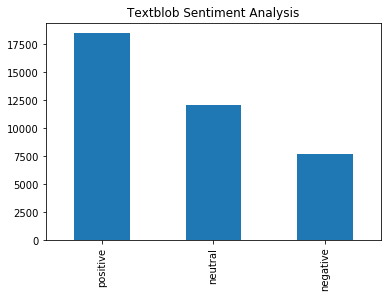

In [13]:
df.tb_sentiment.value_counts().plot(kind='bar',title="Textblob Sentiment Analysis")

Overall, sentiment is mostly positive, which is consistent with the preview above. I'll need to factor in that Textblob is not necessarily 100% accurate, and many times interpretation can be subjective, especially when the tweet itself is negative but the overall opinion toward vaccines is conveyed as positive. 

To look deeper into positive vs negative, I'm going to show the most frequent words and visualize with a word cloud. This will require further text cleaning to make sure I'm getting the most relevant results. I'll start by separating positive, negative, and neutral data into separate dataframes.

In [59]:
negatives = df[df['tb_sentiment'] == 'negative'].reset_index()
positives = df[df['tb_sentiment'] == 'positive'].reset_index()
neutral = df[df['tb_sentiment'] == 'neutral'].reset_index()

When I first ran the text analysis I saw that contractions were being split and strings like "n't" were showing up as frequent words. To solve this I am using a py file and function imported from [this repository](https://github.com/dipanjanS/practical-machine-learning-with-python) in order to map contractions to full words. After defining the fuction and applying it across all the text data, I can see the results in the example below.

In [15]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    """
    Using the contractions.py file cloned to this repository, 
    defines a regex pattern and uses it to map contractions to
    full words and replace them in the text.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


In [61]:
positives['clean_text'] = list(map(expand_contractions, positives['clean_text']))
negatives['clean_text'] = list(map(expand_contractions, negatives['clean_text']))
neutral['clean_text'] = list(map(expand_contractions, neutral['clean_text']))

In [63]:
positives['clean_text'][2] #shows expanded contraction example

'  I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you did not pretend adverse effects do not exist.'

Then I am using NLTK's stopwords list to remove words that don't add meaning (i.e. 'is', 'who', 'for') and adding punctuation, as well as the term 'vaccine' as this should be in every tweet. I can see that Twint is also pulling in some things as weird characters so I'm removing those as well.

In [68]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``', 'amp', "'", '"', "`"]
stopwords_list += punct_list
stopwords_list.extend(['vaccine', 'vaccines'])

Then I'm going to incorporate this into a tokenize function that will map contractions, lowercase words, and remove stopwords and symbols all at once.

In [69]:
def tokenize(tweet):
    
    """
    Preps text data for processing by passing
    several data cleaning techniques at once:
    mapping contractions, lowercasing, and 
    removing stopwords/punctuation
    """
    tokens = nltk.word_tokenize(tweet)
    words_lower = [word.lower() for word in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]

    return words_stopped

In [70]:
processed_data_positive = list(map(tokenize, positives['clean_text']))
processed_data_negative = list(map(tokenize, negatives['clean_text']))
processed_data_neutral = list(map(tokenize, neutral['clean_text']))
processed_data_positive[0]

['definitely',
 'required',
 'every',
 'public',
 'location',
 'library',
 'dmv',
 'etc',
 'also',
 'private',
 'locations',
 'grocery',
 'stores',
 'etc',
 'countries',
 'suffering',
 'lol',
 'us',
 'japan',
 'still',
 'state',
 'emergency',
 'canada',
 'barely',
 'virus',
 'stopped']

To visualize word clouds, I'm compiling a frequency distribution of most common words in positive and negative labeled data.

In [72]:
pos_tweet_concat = []
for tweet in processed_data_positive:
    pos_tweet_concat += tweet
    
pos_tweet_freqdist = FreqDist(processed_data_positive)
# pos_tweet_freqdist.most_common(2000)

TypeError: unhashable type: 'list'

In [74]:
neg_tweet_concat = []
for tweet in processed_data_negative:
    neg_tweet_concat += tweet
    
neg_tweet_freqdist = FreqDist(neg_tweet_concat)
# neg_tweet_freqdist.most_common(2000)

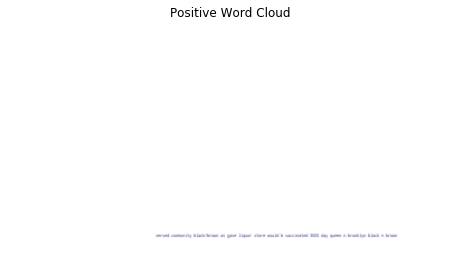

In [75]:
p_wc = WordCloud(background_color="white", max_words=2000)
p_wc.generate_from_frequencies(pos_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()


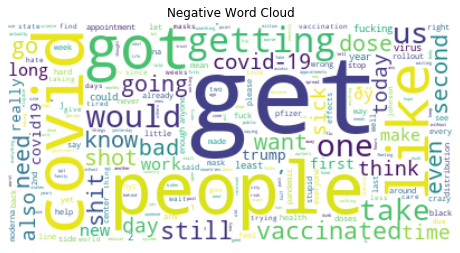

In [76]:
n_wc = WordCloud(background_color="white", max_words=2000)
n_wc.generate_from_frequencies(neg_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(n_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Negative Word Cloud')
plt.show()

The word clouds give some indication of what positive and negative sentiment revolves around: with the positive word cloud there are a lot of terms around availability (today, available, new, appointment, first/second dose), where in the second there are terms that show concern about being able to get a shot as well as the effects: (work, effects, sick, need, time).

Next, I want to create a dataframe that shows how sentiment trends over time, which I'll use to correlate with the vaccination rate data. I'll do this by taking the average polarity score over time overall, and then for each city.

In [ ]:
sent_over_time = df[['date', 'tb_polarity']].sort_values(by ='date')
sent_over_time['date'] =pd.to_datetime(sent_over_time['date'])
sent_over_time = sent_over_time.groupby('date').mean()

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(sent_over_time)
plt.title("Polarity Score Over Time")

Overall, the trend looks pretty random with a few dramatic spikes. Let's take a closer look at different locations. 

In [ ]:
def sent_by_location(df, location):
    
    """
    creates time series of average polarity score 
    over time specific to each location passed in.
    """
    
    location_df = df[df['geo'] == location]
    return location_df[['date', 'tb_polarity']].sort_values(by ='date').groupby('date').mean()

In [ ]:
hou_sent = sent_by_location(df, 'houston')
chi_sent = sent_by_location(df, 'chicago')
nyc_sent = sent_by_location(df, 'nyc')
la_sent = sent_by_location(df, 'la')

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.plot(hou_sent, label='Houston')  
plt.plot(chi_sent, label='Chicago')  
plt.plot(nyc_sent, label='New York City')
plt.plot(la_sent, label='Los Angeles')
plt.xlabel('Date')  
plt.ylabel('Sentiment Score') 
plt.title("Vaccine Sentiment over Time")  
plt.legend() 

In [ ]:
#exporting these dataframes to use in my other notebook

# hou_sent.to_csv('data/houston_sentiment.csv')
# chi_sent.to_csv('data/chicago_sentiment.csv')
# nyc_sent.to_csv('data/nyc_sentiment.csv')
# la_sent.to_csv('data/la_sentiment.csv')

## Cluster Analysis

https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

I'm using unsupervised learning techniques to do a clustering analysis to explore topics of conversation within my data. I'll look at positive vs negative vs neutral topics to see if there is any clear differentiation.

I'm using a Latent Dirichlet Allocation model, a probabilistic model that sees a document as a mix of topics, and a maps each word to a topic. 

This LDA model comes from Gensim and requires an input number of topics, as well a the body of text and a dictionary of word IDs and words.

### Positive Topics

In [ ]:
# Create Dictionary
pos_id2word = corpora.Dictionary(processed_data_positive)
# Create Corpus
pos_texts = processed_data_positive
# Term Document Frequency
pos_corpus = [pos_id2word.doc2bow(text) for text in pos_texts]
# View the result
print(pos_corpus[:1][0][:10])

In [ ]:
# Build LDA model
pos_lda_model = gensim.models.LdaMulticore(corpus=pos_corpus,
                                       id2word=pos_id2word,
                                       num_topics=3)
# Print the keywords in the topics
pprint(pos_lda_model.print_topics())
doc_lda = pos_lda_model[pos_corpus]

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [ ]:
pos_LDAvis_prepared = pyLDAvis.gensim.prepare(pos_lda_model, pos_corpus, pos_id2word)

In [ ]:
with open('pos_LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(pos_LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open('pos_LDAvis_prepared.pickle', 'rb') as f:
    pos_LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared)
pos_LDAvis_prepared

### Negative Topics

In [ ]:
neg_id2word = corpora.Dictionary(processed_data_negative)

neg_texts = processed_data_negative

neg_corpus = [neg_id2word.doc2bow(text) for text in neg_texts]

In [ ]:
# Build LDA model
neg_lda_model = gensim.models.LdaMulticore(corpus=neg_corpus,
                                       id2word=neg_id2word,
                                       num_topics=3)
# Print the keywords in the topics
# pprint(lda_model.print_topics())
neg_doc_lda = neg_lda_model[neg_corpus]

In [ ]:
neg_LDAvis_prepared = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, neg_id2word)

In [ ]:
with open('LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(neg_LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open('LDAvis_prepared.pickle', 'rb') as f:
    neg_LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared)
neg_LDAvis_prepared